In [1]:
import jax
# jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import Partial

import graphgp as gp
import graphgp_cuda as gp_cuda

import matplotlib.pyplot as plt
import cmasher as cmr
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time
from tqdm import tqdm

rng = jr.key(99)

In [2]:
def tree_dot(tree1, tree2):
    leaves = jax.tree_util.tree_map(lambda x, y: jnp.dot(x, y), tree1, tree2)
    return jax.tree_util.tree_reduce(lambda x, y: x + y, leaves)

In [3]:
# Set up test
n_points = 10000
k1, k2 = jr.split(rng)
points = jr.normal(k1, (n_points, 2))
xi = jr.normal(k2, (n_points,))
graph = gp.build_graph(points, n0=100, k=8, cuda=True)
cov_bins = gp.make_cov_bins(r_min=1e-5, r_max=10, n_bins=1000)
cov_func = gp.MaternCovariance(p=0)
cov_vals = cov_func(cov_bins)

values = gp.generate(graph, (cov_bins, cov_vals), xi, cuda=True)

In [4]:
rng, k1, k2, k3 = jr.split(rng, 4)
cov_vals_tangent = cov_vals * jr.normal(k1, (len(cov_vals),))
xi_tangent = jr.normal(k2, (n_points,))
values_tangent = jr.normal(k3, (n_points,))

func = lambda cov_vals, xi: gp.generate(graph, (cov_bins, cov_vals), xi, cuda=True)

val1 = jnp.dot(values_tangent, jax.jvp(func, (cov_vals, xi), (cov_vals_tangent, xi_tangent))[1])
val2 = tree_dot((cov_vals_tangent, xi_tangent), jax.vjp(func, cov_vals, xi)[1](values_tangent))

print(val1)
print(val2)
print((val1 - val2) / val2)

AttributeError: 'tuple' object has no attribute '_iter'

In [5]:
# Test adjoint condition
k1, k2, k3, k4 = jr.split(rng, 4)
n_points, graph, covariance = default_setup(k1)
xi = jr.normal(k2, (n_points,))
xi_tangent = jr.normal(k3, (n_points,))
values_tangent = jr.normal(k4, (n_points,))
func = Partial(gp.generate, graph, covariance, cuda=True)

val1 = jnp.dot(values_tangent, jax.jvp(func, (xi,), (xi_tangent,))[1])
val2 = jnp.dot(xi_tangent, jax.vjp(func, xi)[1](values_tangent)[0])

NameError: name 'default_setup' is not defined

In [6]:
cuda_vjp = jax.vjp(lambda cutoff: gp.generate(graph, (cov_bins, cov_func(cov_bins, cutoff=cutoff)), xi, cuda=True), 0.1)[1](values)
cuda_vjp

AttributeError: 'tuple' object has no attribute '_iter'

In [6]:
jax_vjp = jax.vjp(lambda cutoff: gp.generate_jit(graph, (cov_bins, cov_func(cov_bins, cutoff=cutoff)), xi, cuda=False), 0.1)[1](values)
jax_vjp

(Array(17476.389, dtype=float32, weak_type=True),)

In [7]:
cuda_vjp = jax.vjp(lambda cov_vals: gp.generate(graph, (cov_bins, cov_vals), xi, cuda=True), cov_vals)[1](values)
cuda_vjp

(Array([ 2.21415796e+03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.0

In [8]:
jax_vjp = jax.vjp(lambda cov_vals: gp.generate_jit(graph, (cov_bins, cov_vals), xi, cuda=False), cov_vals)[1](values)
jax_vjp

(Array([ 2.21409351e+03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.0

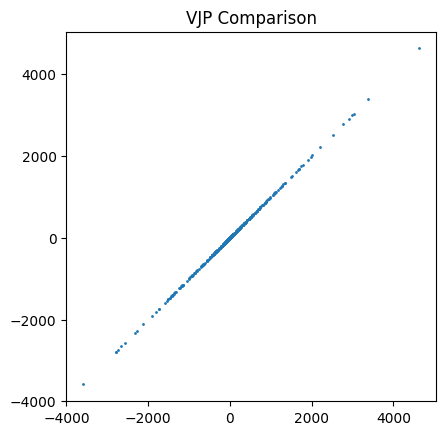

In [9]:
plt.scatter(cuda_vjp, jax_vjp, s=1)
plt.gca().set(aspect='equal', title='VJP Comparison')
plt.show()

Text(0.5, 1.0, 'VJP Difference')

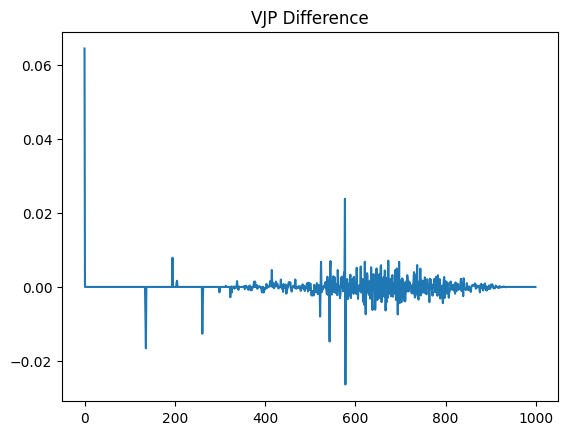

In [10]:
plt.plot(cuda_vjp[0] - jax_vjp[0])
plt.title('VJP Difference')

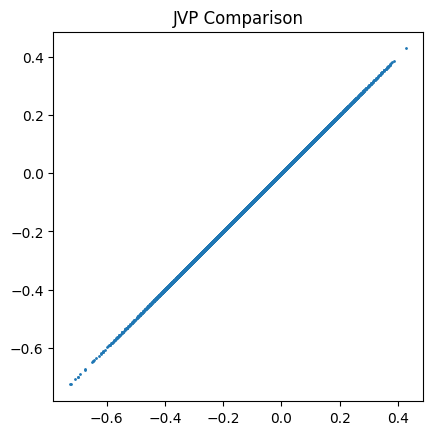

In [11]:
jax_jvp = jax.jvp(lambda cutoff: gp.generate_jit(graph, (cov_bins, cov_func(cov_bins, cutoff=cutoff)), xi, cuda=False), (1.0,), (0.5,))
cuda_jvp = jax.jvp(lambda cutoff: gp.generate(graph, (cov_bins, cov_func(cov_bins, cutoff=cutoff)), xi, cuda=True), (1.0,), (0.5,))
# plt.plot(jax_jvp[1] - cuda_jvp[1])
plt.scatter(cuda_jvp[1], jax_jvp[1], s=1)
plt.gca().set(aspect='equal', title='JVP Comparison')
plt.show()

Text(0.5, 1.0, 'JVP Difference')

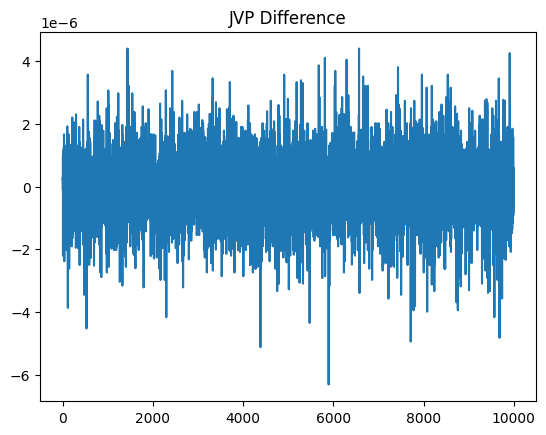

In [12]:
plt.plot(jax_jvp[0] - cuda_jvp[0])
plt.title('JVP Difference')

In [7]:
points = jnp.array([0.0, 0.5, 2.0])[:,None]
neighbors = jnp.array([[0, 1]])
offsets = (2, 3)
cov_bins = gp.make_cov_bins(r_min=1e-3, r_max=10, n_bins=100)
cov_func = gp.MaternCovariance(p=0)
cov_vals = cov_func(cov_bins)

rng, k1 = jr.split(rng)
xi = jr.normal(k1, (len(points),))
graph = gp.Graph(points, neighbors, offsets)
initial_values = gp.generate_dense(points[:2], (cov_bins, cov_vals), xi[:2])
values = gp.generate(graph, (cov_bins, cov_vals), xi)
xi = xi[2:]
offsets = jnp.array(offsets)

gp_cuda.primitive.refine_nonlinear_vjp(points, neighbors, offsets, cov_bins, cov_vals, initial_values, xi, values, jnp.ones_like(values))[1:]

(Array([-0.6254356 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.09664513,  0.0

In [8]:
jax.vjp(lambda cov_vals, initial_values, xi: gp.refine(points, neighbors, offsets, (cov_bins, cov_vals), initial_values, xi), cov_vals, initial_values, xi)[1](jnp.ones_like(values))

(Array([-0.6254355 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.09664507,  0.0